2024-08-26 16:24:58.559 | INFO     | kfactory.kcell:show:7894 - klive v0.3.3: Opened file '/tmp/3814713293.gds'
2024-08-26 16:24:58.560 | WARNING  | kfactory.kcell:show:7940 - KLayout GUI version is older than the python klayout.GUI:0.28.16 Python:0.29.6. This might cause missing,unfunctional, or erroneous features. Please update your GUI to a version equal or higher than the python version for optimal performance.


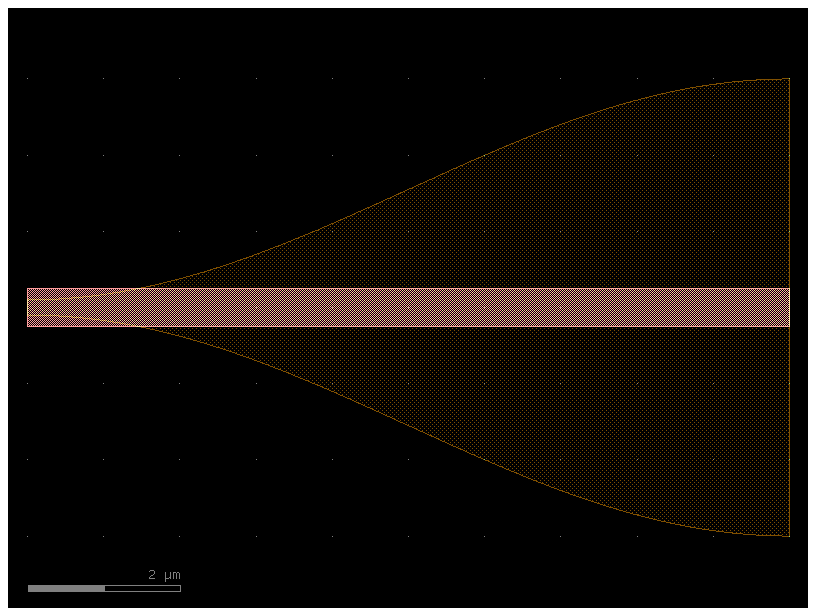

In [2]:
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
from gdsfactory.generic_tech import get_generic_pdk

from gplugins.meow import MEOW

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

LAYER_STACK = PDK.layer_stack
c = gf.components.taper_cross_section_sine()
c.plot()
c.show()

In [3]:
layer_stack = LAYER_STACK

filtered_layer_stack = gf.technology.LayerStack(
    layers={
        k: layer_stack.layers[k]
        for k in (
            "slab90",
            "core",
            "box",
            "clad",
        )
    }
)

In [4]:
eme = MEOW(
    component=c, layer_stack=filtered_layer_stack, wavelength=1.55, overwrite=True
)

In [5]:
eme.plot_structure()


ValueError: Nothing to visualize!

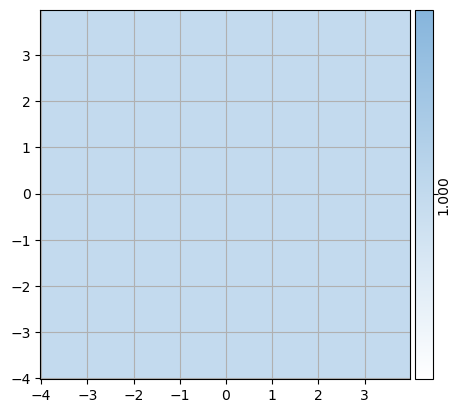

In [6]:
eme.plot_cross_section(xs_num=0)

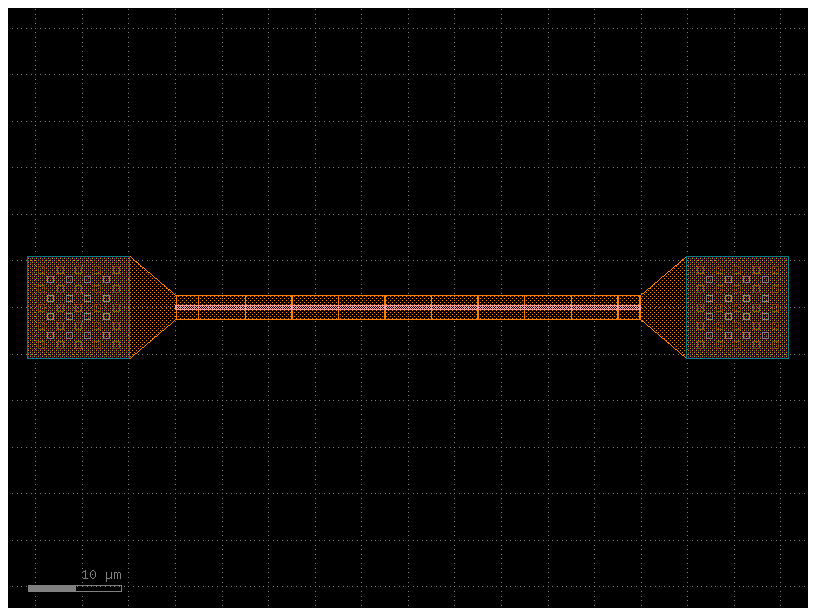

In [7]:
import gdsfactory as gf
import meshio
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.technology import LayerStack
from skfem.io import from_meshio

from gplugins.gmsh import create_physical_mesh, get_mesh

PDK = get_generic_pdk()
PDK.activate()

LAYER_STACK = PDK.layer_stack
LAYER_STACK.layers["heater"].thickness = 0.13
LAYER_STACK.layers["heater"].zmin = 2.2

heater = gf.components.straight_heater_metal(length=50)
heater.plot()

In [8]:
filtered_layer_stack = LayerStack(
    layers={
        k: gf.pdk.get_layer_stack().layers[k]
        for k in ("slab90", "core", "via_contact", "heater")
    }
)

In [9]:
filename = "mesh"


def mesh_with_physicals(mesh, filename):
    mesh_from_file = meshio.read(f"{filename}.msh")
    return create_physical_mesh(mesh_from_file, "triangle")

  0%|          | 0/2 [00:00<?, ?it/s]

Info    : Meshing 1D...nts - Building splits of containers                                                                                     
Info    : [  0%] Meshing curve 1 (Line)
Info    : [  0%] Meshing curve 2 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.000817351s, CPU 0.002291s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00346826s, CPU 0.015339s)
Info    : 36 nodes 78 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'
Info    : Writing '/tmp/tmp6oef68rk/mesh.msh'...
Info    : Done writing '/tmp/tmp6oef68rk/m

[]

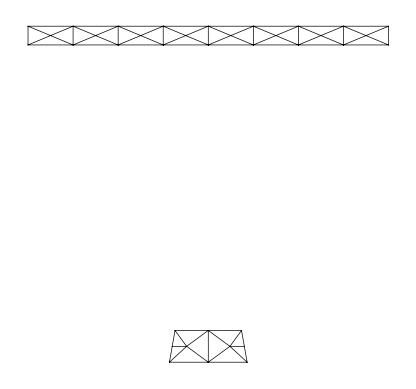

In [10]:
mesh = get_mesh(
    component=heater,
    type="uz",
    xsection_bounds=[(4, -4), (4, 4)],
    layer_stack=filtered_layer_stack,
    filename=f"{filename}.msh",
)
mesh = mesh_with_physicals(mesh, filename)
mesh = from_meshio(mesh)
mesh.draw().plot()

In [11]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.thermal import solve_thermal
from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

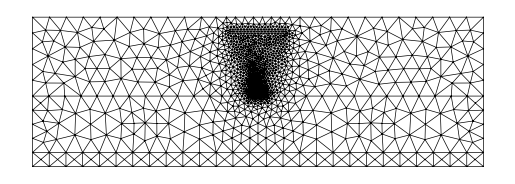

In [12]:
w_sim = 8 * 2
h_clad = 2.8
h_box = 2
w_core = 0.5
h_core = 0.22
h_heater = 0.14
w_heater = 2
offset_heater = 2 + (h_core + h_heater) / 2
h_silicon = 0.5

polygons = OrderedDict(
    bottom=LineString(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
    core=Polygon(
        [
            (-w_core / 2, -h_core / 2),
            (-w_core / 2, h_core / 2),
            (w_core / 2, h_core / 2),
            (w_core / 2, -h_core / 2),
        ]
    ),
    heater=Polygon(
        [
            (-w_heater / 2, -h_heater / 2 + offset_heater),
            (-w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, -h_heater / 2 + offset_heater),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    wafer=Polygon(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
)

resolutions = dict(
    core={"resolution": 0.04, "distance": 1},
    clad={"resolution": 0.6, "distance": 1},
    box={"resolution": 0.6, "distance": 1},
    heater={"resolution": 0.1, "distance": 1},
)

mesh = from_meshio(
    mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6)
)
mesh.draw().show()

 90%|█████████ | 9/10 [00:03<00:00,  3.03it/s]

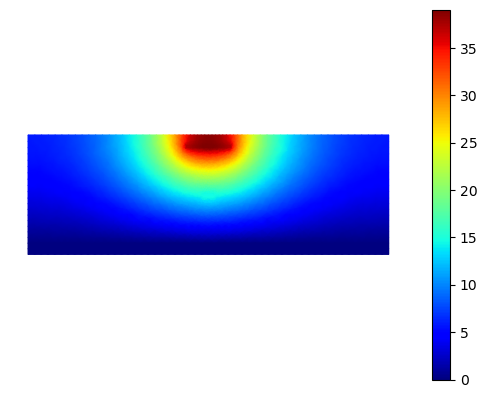

/tmp/ipykernel_8073/3480375762.py:40: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes[0].show(modes[0].E.real)


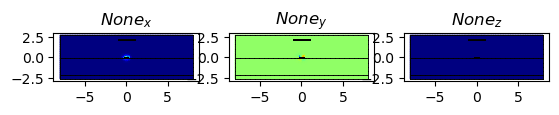

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

Phase shift: 3.786321638786245


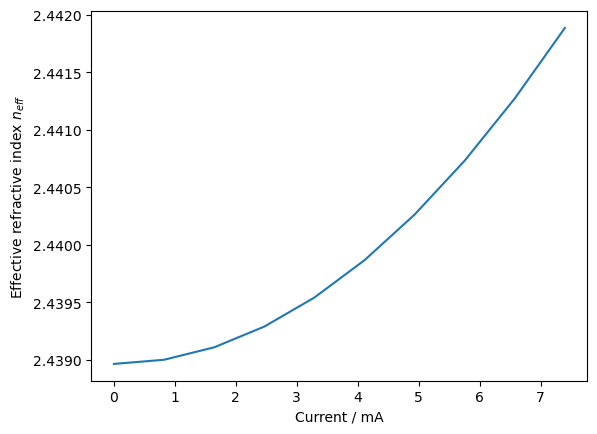

In [13]:
currents = np.linspace(0.0, 7.4e-3, 10)
current_densities = currents / polygons["heater"].area
neffs = []

for current_density in tqdm(current_densities):
    basis0 = Basis(mesh, ElementTriP0(), intorder=4)
    thermal_conductivity_p0 = basis0.zeros()
    for domain, value in {
        "core": 90,
        "box": 1.38,
        "clad": 1.38,
        "heater": 28,
        "wafer": 148,
    }.items():
        thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
    thermal_conductivity_p0 *= 1e-12  # 1e-12 -> conversion from 1/m^2 -> 1/um^2

    basis, temperature = solve_thermal(
        basis0,
        thermal_conductivity_p0,
        specific_conductivity={"heater": 2.3e6},
        current_densities={"heater": current_density},
        fixed_boundaries={"bottom": 0},
    )

    if current_density == current_densities[-1]:
        basis.plot(temperature, shading="gouraud", colorbar=True)
        plt.show()

    temperature0 = basis0.project(basis.interpolate(temperature))
    epsilon = basis0.zeros() + (1.444 + 1.00e-5 * temperature0) ** 2
    epsilon[basis0.get_dofs(elements="core")] = (
        3.4777 + 1.86e-4 * temperature0[basis0.get_dofs(elements="core")]
    ) ** 2
    # basis0.plot(epsilon, colorbar=True).show()

    modes = compute_modes(basis0, epsilon, wavelength=1.55, num_modes=1, solver="scipy")

    if current_density == current_densities[-1]:
        modes[0].show(modes[0].E.real)

    neffs.append(np.real(modes[0].n_eff))

print(f"Phase shift: {2 * np.pi / 1.55 * (neffs[-1] - neffs[0]) * 320}")
plt.xlabel("Current / mA")
plt.ylabel("Effective refractive index $n_{eff}$")
plt.plot(currents * 1e3, neffs)
plt.show()

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from gplugins.process.implant_tables import *

Text(0.5, 1.0, 'Ion implantation in silicon, range')

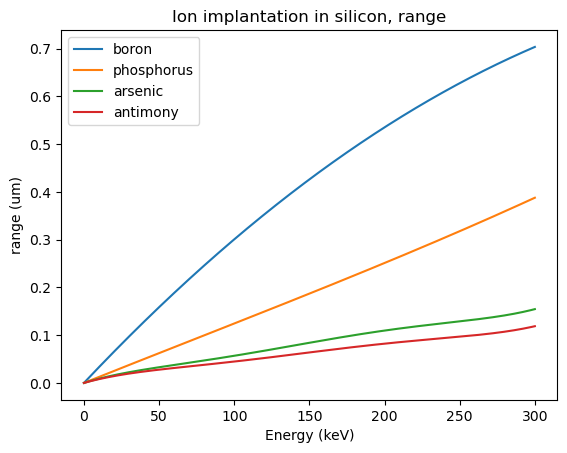

In [15]:
energies = np.linspace(0, 300, 1000)  # keV

for dopant in ["boron", "phosphorus", "arsenic", "antimony"]:
    plt.plot(energies, depth_in_silicon[dopant](energies), label=dopant)

plt.xlabel("Energy (keV)")
plt.ylabel("range (um)")
plt.legend(loc="best")
plt.title("Ion implantation in silicon, range")

Text(0.5, 1.0, 'Ion implantation in silicon, straggle')

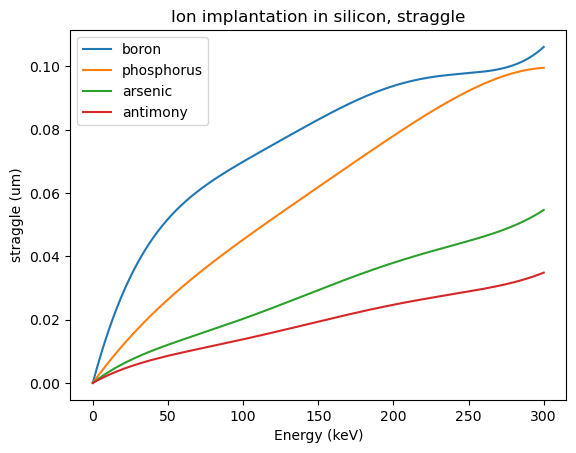

In [16]:
for dopant in ["boron", "phosphorus", "arsenic", "antimony"]:
    plt.plot(energies, straggle_in_silicon[dopant](energies), label=dopant)

plt.xlabel("Energy (keV)")
plt.ylabel("straggle (um)")
plt.legend(loc="best")
plt.title("Ion implantation in silicon, straggle")

In [1]:
from pathlib import Path
from shutil import rmtree
from srim import Ion, Layer, Target

TypeError: load() missing 1 required positional argument: 'Loader'

2024-08-26 16:40:23.538 | INFO     | kfactory.kcell:show:7894 - klive v0.3.3: Opened file '/tmp/492795784.gds'
2024-08-26 16:40:23.539 | WARNING  | kfactory.kcell:show:7940 - KLayout GUI version is older than the python klayout.GUI:0.28.16 Python:0.29.6. This might cause missing,unfunctional, or erroneous features. Please update your GUI to a version equal or higher than the python version for optimal performance.


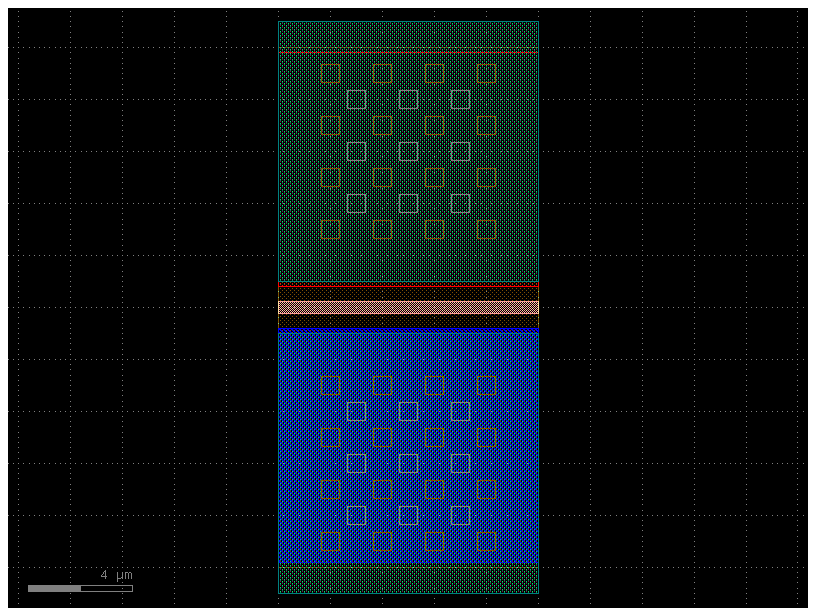

In [2]:
import gdsfactory as gf
import meshio
from gdsfactory.generic_tech import LAYER_STACK, get_generic_pdk
from gdsfactory.technology import LayerStack
from skfem.io import from_meshio

from gplugins.gmsh.get_mesh import create_physical_mesh, get_mesh

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

waveguide = gf.components.straight_pin(length=10, taper=None)
waveguide.plot()
waveguide.show()

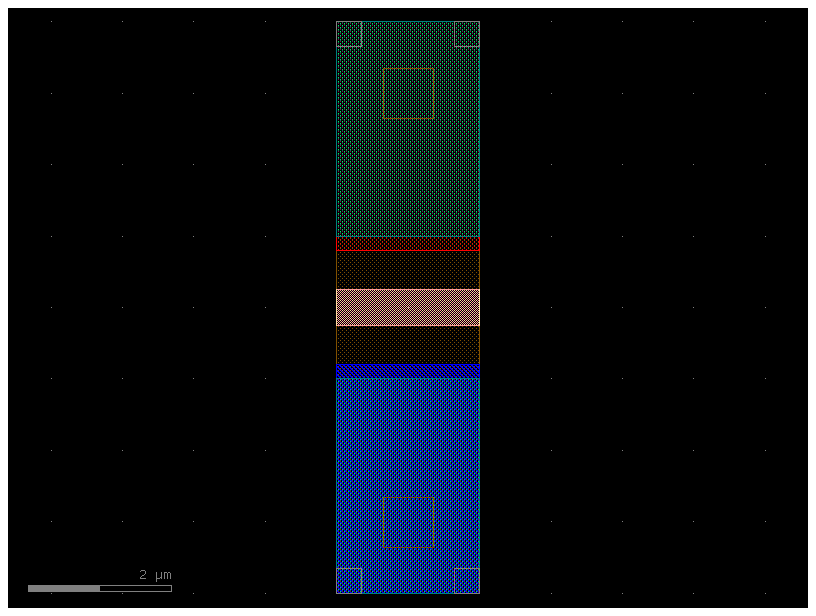

In [3]:
import gdsfactory as gf
import meshio
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.pdk import get_layer_stack
from gdsfactory.technology import LayerStack
from skfem.io import from_meshio

from gplugins.gmsh.get_mesh import create_physical_mesh, get_mesh

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

waveguide = gf.components.straight_pin(length=10, taper=None)
waveguide.trim(left=3, right=5, top=+4, bottom=-4)
waveguide.plot()

In [4]:
filtered_layer_stack = LayerStack(
    layers={
        k: get_layer_stack().layers[k]
        for k in (
            "slab90",
            "core",
            "via_contact",
        )
    }
)

In [5]:
filename = "mesh"


def mesh_with_physicals(mesh, filename):
    mesh_from_file = meshio.read(f"{filename}.msh")
    return create_physical_mesh(mesh_from_file, "triangle")

  0%|          | 0/3 [00:00<?, ?it/s]

Info    : Meshing 1D...nts - Splitting faces                                                                                                   
Info    : [  0%] Meshing curve 1 (Line)
Info    : [  0%] Meshing curve 2 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [  0%] Meshing curve 5 (Line)
Info    : [  0%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [  0%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%] Meshing curve 24 (Line)
Info    : [ 50%] Meshing curve 25 (Line)
Info    : [ 50%] Meshing curve 26 (Line)
Info    : [ 50%] Meshing curve 27 (Line)
Inf

[]

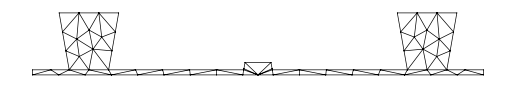

In [8]:
mesh = get_mesh(
    component=waveguide,
    type="uz",
    xsection_bounds=[(4, -4), (4, 4)],
    layer_stack=filtered_layer_stack,
    filename=f"{filename}.msh",
)
mesh = mesh_with_physicals(mesh, filename)
mesh = from_meshio(mesh)
mesh.draw().plot()

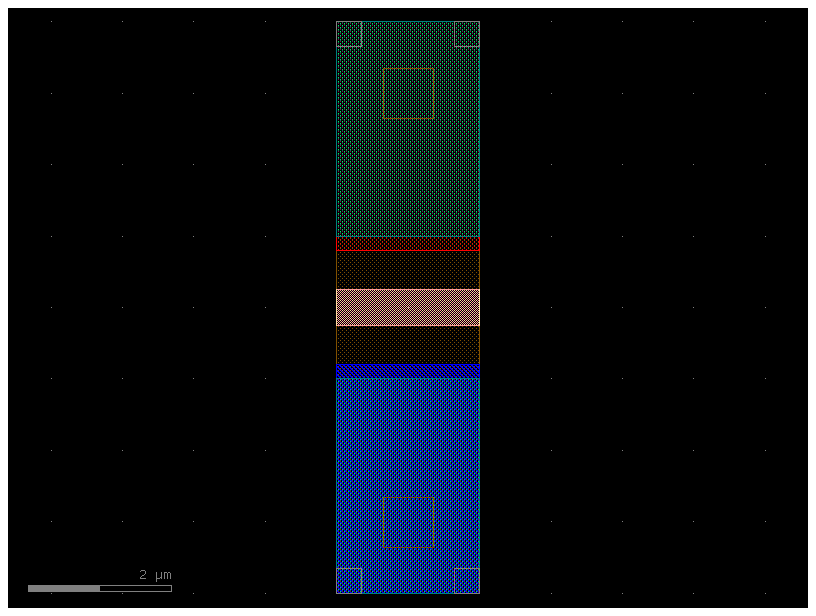

In [9]:
import gdsfactory as gf
import meshio
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.pdk import get_layer_stack
from gdsfactory.technology import LayerStack
from skfem.io import from_meshio

from gplugins.gmsh.get_mesh import create_physical_mesh, get_mesh

PDK = get_generic_pdk()
PDK.activate()
gf.config.rich_output()

waveguide = gf.components.straight_pin(length=10, taper=None)
waveguide.trim(left=3, right=5, top=+4, bottom=-4)
waveguide.plot()


filtered_layer_stack = LayerStack(
    layers={
        k: get_layer_stack().layers[k]
        for k in (
            "slab90",
            "core",
            "via_contact",
        )
    }
)

filename = "mesh"


def mesh_with_physicals(mesh, filename):
    mesh_from_file = meshio.read(f"{filename}.msh")
    return create_physical_mesh(mesh_from_file, "triangle")

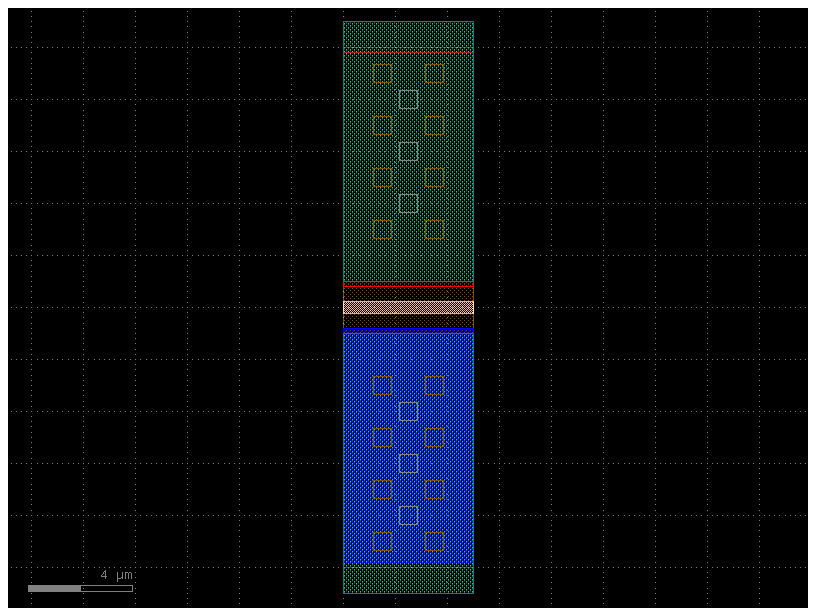

In [10]:
import gdsfactory as gf
import meshio
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.pdk import get_layer_stack
from gdsfactory.technology import LayerStack
from skfem.io import from_meshio

from gplugins.gmsh.get_mesh import create_physical_mesh, get_mesh

PDK = get_generic_pdk()
PDK.activate()
gf.config.rich_output()

waveguide = gf.components.straight_pin(length=5, taper=None)
waveguide.plot()

In [11]:
filtered_layer_stack = LayerStack(
    layers={
        k: get_layer_stack().layers[k]
        for k in (
            "slab90",
            "core",
            "via_contact",
            "metal1",
            "via1",
            "metal2",
            "via2",
            "metal3",
        )
    }
)

filename = "mesh"


def mesh_with_physicals(mesh, filename):
    mesh_from_file = meshio.read(f"{filename}.msh")
    return create_physical_mesh(mesh_from_file, "tetra")

In [12]:
mesh = get_mesh(
    component=waveguide,
    type="3D",
    layer_stack=filtered_layer_stack,
    filename=f"{filename}.msh",
    default_characteristic_length=1,
    verbosity=5,
)

  0%|          | 0/8 [00:00<?, ?it/s]

Info    : Meshing 1D...nts                                                                                                                     
Info    : [  0%] Meshing curve 1 (Line)
Info    : [  0%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 18 (Line)
Info    : [ 10%] Meshing curve 20 (Line)
Info    : [ 10%] Meshing curve 21 (Line)
Info

AttributeError: 'MeshTet1' object has no attribute 'show'

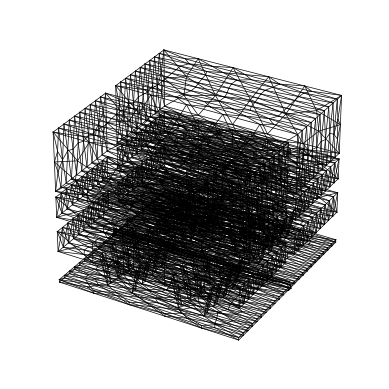

In [14]:
mesh = mesh_with_physicals(mesh, filename)
mesh = from_meshio(mesh)
mesh.draw().plot(xs=[], ys=[])


In [15]:
from functools import partial

import gdsfactory as gf
import numpy as np
import ray
import ray.air
import ray.air.session
from gdsfactory.config import PATH
from gdsfactory.generic_tech import get_generic_pdk
from ray import tune

import gplugins.gmeep as gm

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

tmp = PATH.optimiser
tmp.mkdir(exist_ok=True)

ModuleNotFoundError: No module named 'ray'

In [1]:
from functools import partial

import gdsfactory as gf
import numpy as np
import ray
import ray.air
import ray.air.session
from gdsfactory.config import PATH
from gdsfactory.generic_tech import get_generic_pdk
from ray import tune

import gplugins.gmeep as gm

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

tmp = PATH.optimiser
tmp.mkdir(exist_ok=True)

Using MPI version 4.1, 1 processes
2024-08-26 16:46:03.728 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.29.0' installed at ['/home/hamed/anaconda3/lib/python3.11/site-packages/meep']


In [2]:
def loss_S21_L1(x, target):
    r"""Loss function. Returns :math:`$\sum_i L_1(x_i)$` and :math:`$x$` as a tuple"""
    return np.abs(target - x), x

In [3]:
loss = partial(loss_S21_L1, target=0.5)

In [4]:
search_config = {
    "length_mmi": tune.uniform(0.05, 2),
    "width_mmi": tune.uniform(0.05, 2),
}

# pylint: disable=wrong-import-position,ungrouped-imports
from ray.tune.search.hyperopt import HyperOptSearch

tune_config = tune.TuneConfig(
    metric="loss",
    mode="min",
    search_alg=HyperOptSearch(),
    max_concurrent_trials=2,  # simulations to run in parallel
    num_samples=-1,  # max iterations, can be -1 for infinite
    time_budget_s=60
    * 20,  # time after which optimisation is stopped. May be useful along with ``num_samples=-1``.
)

In [5]:
use_mpi = False  # change this to true if you have MPI support

In [6]:
def trainable_simulations(config):
    """Training step, or `trainable`, function for Ray Tune to run simulations and return results."""

    # Component to optimise
    component = gf.components.mmi1x2(**config)

    # Simulate and get output
    dirpath = tmp / ray.air.session.get_trial_id()

    meep_params = dict(
        component=component,
        run=True,
        dirpath=dirpath,
        wavelength_start=1.5,
        # wavelength_stop=1.6,
        wavelength_points=1,
    )

    if use_mpi:  # change this to false if no MPI support
        s_params = gm.write_sparameters_meep_mpi(
            cores=2,
            **meep_params,  # set this to be same as in `tune.Tuner`
        )
        s_params = np.load(s_params)  # parallel version returns filepath to npz instead
    else:
        s_params = gm.write_sparameters_meep(**meep_params)

    s_params_abs = np.abs(s_params["o2@0,o1@0"]) ** 2

    loss_x, x = loss(s_params_abs)
    if not np.isscalar(x):  # for many wavelengths, consider sum and mean
        loss_x, x = loss_x.sum(), x.mean()

    return {"loss": loss_x, "value": x}

    # ALTERNATIVE
    # For a shell-based solution to more software, subprocess.run is recommended roughly as below
    # interpreter = shutil.which('bash')
    # subprocess.run(
    #     [interpreter, '-c', './generated_simulation.sh'],
    #     cwd=dirpath,
    #     check=True,
    # )

In [7]:
tuner = tune.Tuner(
    tune.with_resources(
        trainable_simulations, {"cpu": 2}
    ),  # maximum resources given to a worker, it also supports 'gpu'
    param_space=search_config,
    tune_config=tune_config,
    run_config=ray.air.RunConfig(
        local_dir=tmp / "ray_results",
        checkpoint_config=ray.air.CheckpointConfig(checkpoint_frequency=1),
        log_to_file=True,
        verbose=2,  # Intermediate results in Jupyter
    ),
)

# Previous simulations can be restored with, see https://docs.ray.io/en/latest/tune/tutorials/tune-stopping.html
# tuner = Tuner.restore(path=tmp / "ray_results/my_experiment")

results = tuner.fit()

DeprecationWarning: The `RunConfig(local_dir)` argument is deprecated. You should set the `RunConfig(storage_path)` instead.See the docs: https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html#setting-the-local-staging-directory

In [1]:
from functools import partial

import gdsfactory as gf
import numpy as np
import pyswarms as ps
from gdsfactory.config import PATH
from gdsfactory.generic_tech import get_generic_pdk

import gplugins.gmeep as gm

# Set up GDSFactory and PDK
gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

# Create a working directory for the PSO optimization
wrk_dir = PATH.cwd / "extra"
wrk_dir.mkdir(exist_ok=True)


# ## Define the loss function used in the PSO optimization
def loss_S21_L1(x, target):
    r"""Loss function. Returns :math:`$\sum_i L_1(x_i)$` and :math:`$x$` as a tuple"""
    return np.abs(target - x), x


# ## Define the trainable function for the PSO optimization
def trainable_simulations(x, loss=lambda x: x):
    """Training step, or `trainable`, function for Ray Tune to run simulations and return results."""
    loss_arr = []
    use_mpi = False

    for xi in x:
        # Component to optimize
        component = gf.components.mmi1x2(length_mmi=xi[0], width_mmi=xi[1])

        # Simulate and get output
        meep_params = dict(
            component=component,
            run=True,
            dirpath=wrk_dir,
            wavelength_start=1.5,
            wavelength_points=1,
            is_3d=False,
        )
        if use_mpi:  # change this to false if no MPI support
            s_params = gm.write_sparameters_meep_mpi(
                cores=2,
                **meep_params,  # set this to be the same as in `tune.Tuner`
            )
            s_params = np.load(
                s_params
            )  # parallel version returns the filepath to npz instead
        else:
            s_params = gm.write_sparameters_meep(**meep_params)

        s_params_abs = np.abs(s_params["o2@0,o1@0"]) ** 2

        loss_x, x = loss(s_params_abs)
        if not np.isscalar(x):  # for many wavelengths, consider sum and mean
            loss_x, x = -loss_x.sum(), x.mean()

        loss_arr.append(loss_x)

    return np.asarray(loss_arr)


# Define the target value for the loss function
loss = partial(loss_S21_L1, target=0.5)
func = partial(trainable_simulations, loss=loss)

# Create bounds for the optimization
max_bound = np.array([0.05, 0.05])
min_bound = np.array([2, 2])
bounds = (min_bound, max_bound)

# Set options for the PSO optimizer
options = {"c1": 0.5, "c2": 0.3, "w": 0.9}

# Create an instance of the PSO optimizer
optimizer = ps.single.GlobalBestPSO(
    n_particles=10, dimensions=2, options=options, bounds=bounds
)

Using MPI version 4.1, 1 processes
2024-08-26 16:48:20.249 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.29.0' installed at ['/home/hamed/anaconda3/lib/python3.11/site-packages/meep']


In [2]:
# Perform the optimization. We run only comment these lines for demo purposes
 cost, pos = optimizer.optimize(func, iters=100)
 plot_cost_history(cost_history=optimizer.cost_history)
 plt.show()

IndentationError: unexpected indent (468907670.py, line 2)